In [1]:
import matplotlib.pyplot as plt
import numpy as np

import iris
import iris.quickplot as qplt

%matplotlib inline

In [2]:
#directory = '/g/data/r87/dbi599/drstree/CMIP5/GCM/CSIRO-BOM/ACCESS1-0/historical/mon/ocean/'
directory = '/Users/damienirving/Downloads/Data/'
fname = directory+'ohc-metrics_Omon_ACCESS1-0_historical_r1i1p1_all.nc'

In [3]:
cube_globe = iris.load_cube(fname, 'ocean heat content globe')
cube_sthext = iris.load_cube(fname, 'ocean heat content southern extratropics')
cube_notsthext = iris.load_cube(fname, 'ocean heat content outside southern extratropics')

writing [iris.fileformats._pyke_rules.compiled_krb]/fc_rules_cf_fc.py
writing [iris.fileformats._pyke_rules.compiled_krb]/compiled_pyke_files.py
/Users/damienirving/anaconda/envs/default/lib/python2.7/site-packages/iris/fileformats/cf.py:1139: UserWarning: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warnings.warn(msg)


In [4]:
print cube_globe

ocean heat content globe / (10^22 J) (time: 1872)
     Dimension coordinates:
          time                            x
     Attributes:
          Conventions: CF-1.5
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_fx_ACCESS1-0_historical_r0i0p0.nc...
          branch_time: 109207.0
          cmor_version: 2.8.0
          contact: The ACCESS wiki: http://wiki.csiro.au/confluence/display/ACCESS/Home. Contact...
          depth_bounds: ohc integrated over full depth of input data (5.000000 down to 5831.29...
          experiment: historical
          experiment_id: historical
          forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4, CFC11, CFC12, CFC113,...
          frequency: mon
          history: Wed May 18 13:19:16 2016: /g/data/r87/dbi599/miniconda2/envs/default/bin/python...
          initialization_method: 1
          institute_id: CSIRO-BOM
          institution: CSIRO (Commonwealth Scientific and Indu

In [5]:
cube_globe = cube_globe.rolling_window('time', iris.analysis.MEAN, 12)
cube_sthext = cube_sthext.rolling_window('time', iris.analysis.MEAN, 12)
cube_notsthext = cube_notsthext.rolling_window('time', iris.analysis.MEAN, 12)

/Users/damienirving/anaconda/envs/default/lib/python2.7/site-packages/iris/cube.py:3381: UserWarning: The bounds of coordinate u'time' were ignored in the rolling window operation.
  'the rolling window operation.' % coord_.name())


In [6]:
print cube_globe

ocean heat content globe / (10^22 J) (time: 1861)
     Dimension coordinates:
          time                            x
     Attributes:
          Conventions: CF-1.5
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_fx_ACCESS1-0_historical_r0i0p0.nc...
          branch_time: 109207.0
          cmor_version: 2.8.0
          contact: The ACCESS wiki: http://wiki.csiro.au/confluence/display/ACCESS/Home. Contact...
          depth_bounds: ohc integrated over full depth of input data (5.000000 down to 5831.29...
          experiment: historical
          experiment_id: historical
          forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4, CFC11, CFC12, CFC113,...
          frequency: mon
          history: Wed May 18 13:19:16 2016: /g/data/r87/dbi599/miniconda2/envs/default/bin/python...
          initialization_method: 1
          institute_id: CSIRO-BOM
          institution: CSIRO (Commonwealth Scientific and Indu

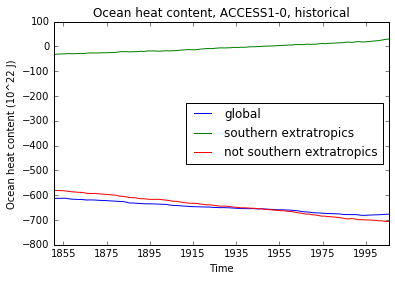

In [7]:
qplt.plot(cube_globe.coord('time'), cube_globe, label='global')
qplt.plot(cube_sthext.coord('time'), cube_sthext, label='southern extratropics')
qplt.plot(cube_notsthext.coord('time'), cube_notsthext, label='not southern extratropics')

plt.legend(loc='best')
plt.title('Ocean heat content, ACCESS1-0, historical')
plt.ylabel('Ocean heat content (%s)' %(cube_globe.units))

qplt.show()

In [11]:
diff = cube_sthext - cube_notsthext

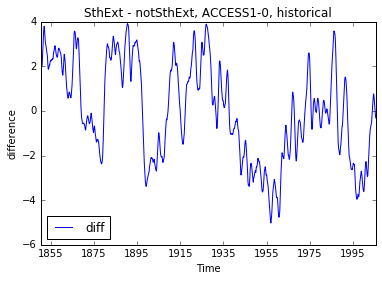

In [12]:
qplt.plot(diff.coord('time'), diff, label='diff')

plt.legend(loc='best')
plt.title('SthExt - notSthExt, ACCESS1-0, historical')
plt.ylabel('difference')

qplt.show()

Now that I've got the dummy difference data, I need to take the linear trend in 10 year windows. I'm following the example of how to make an aggregator in Iris found [here](http://scitools.org.uk/iris/docs/latest/examples/General/custom_aggregation.html#general-custom-aggregation).

In [13]:
from iris.util import rolling_window
from iris.analysis import Aggregator
from scipy import stats
import numpy

In [14]:
print diff

unknown / (10^22 J m-2)             (time: 1861)
     Dimension coordinates:
          time                           x


In [27]:
windowed_ratio = rolling_window(diff.data, window=12, axis=0)

In [28]:
print windowed_ratio.shape

(1850, 12)


In [29]:
def calc_slope(y, x):
    """ """
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    return slope


def linear_trend(data, axis, window_size):
    """ """

    window_array = rolling_window(data, window=window_size, axis=axis)

    x_axis = numpy.arange(0, window_size)    
    trend = numpy.apply_along_axis(calc_slope, -1, window_array, x_axis)
    
    return trend
    

In [30]:
diff_trends = linear_trend(diff.data, 0, 12)

In [31]:
diff_trends.shape

(1850,)

In [32]:
diff_trends[0]

0.043823062123118581

In [33]:
stats.linregress(numpy.arange(0, 12), diff.data[0:12])

LinregressResult(slope=0.043823062123118581, intercept=2.0038454899421105, rvalue=0.58293719465982574, pvalue=0.046668550794181092, stderr=0.019315836734173069)

In [34]:
trend_cube = iris.cube.Cube(diff_trends, dim_coords_and_dims=[(diff.coord('time')[5:-6], 0)])

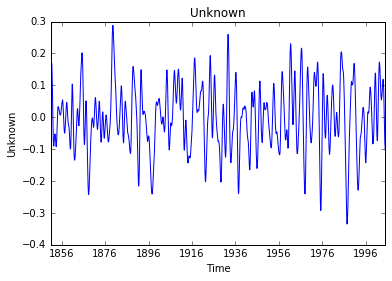

In [35]:
#qplt.plot(diff.coord('time'), diff, label='difference')
qplt.plot(trend_cube.coord('time'), trend_cube, label='trend')

#plt.legend(loc='best')
#plt.title('SthExt / notSthExt, ACCESS1-0, historical')
#plt.ylabel('ratio')

qplt.show()

In [36]:
import seaborn

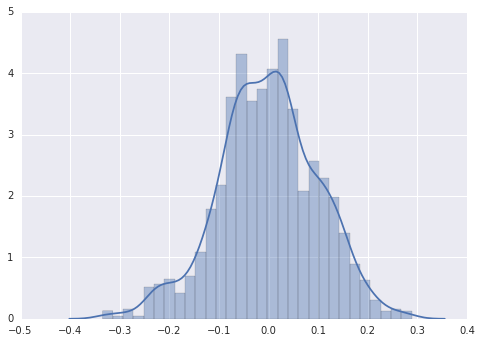

In [38]:
seaborn.distplot(trend_cube.data)